## ***IMPORTS***

In [14]:

import numpy as np
import matplotlib.pyplot as plt
from numpy import pi, cos, sin, exp
from numpy.linalg import norm
from matplotlib.colors import TwoSlopeNorm
import itertools

from qiskit_aer import AerSimulator
from qiskit_aer.noise import NoiseModel 
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister, transpile
from qiskit.quantum_info import partial_trace, Statevector, state_fidelity, DensityMatrix, Operator, Pauli
from qiskit_aer.noise import depolarizing_error, pauli_error, NoiseModel
from qiskit_aer.library import save_stabilizer, set_stabilizer, save_density_matrix
from qiskit.visualization import plot_histogram
from qiskit.circuit import Clbit  
from qiskit.circuit.library import Initialize, UnitaryGate




In [15]:


xmatrix = np.array([[0,1], [1,0]], dtype=complex)
zmatrix = np.array([[1,0], [0,-1]], dtype=complex)
imatrix = np.eye(2, dtype=complex)
hmatrix = np.array([[1,1], [1,-1]], dtype=complex) / np.sqrt(2)
ymatrix = np.array([[0, -1j],[1j, 0]], dtype=complex)
smatrix = np.array([[1,0], [0,1j]], dtype=complex)
tmatrix = np.array([[1,0], [0,np.exp(1j*pi/4)]], dtype=complex)
sdagmatrix = np.array([[1,0], [0,-1j]], dtype=complex)


toffolimatrix = np.array([
    [1, 0, 0, 0, 0, 0, 0, 0],  # |000> -> |000>
    [0, 1, 0, 0, 0, 0, 0, 0],  # |001> -> |001>
    [0, 0, 1, 0, 0, 0, 0, 0],  # |010> -> |010>
    [0, 0, 0, 1, 0, 0, 0, 0],  # |011> -> |011>
    [0, 0, 0, 0, 1, 0, 0, 0],  # |100> -> |100>
    [0, 0, 0, 0, 0, 1, 0, 0],  # |101> -> |101>
    [0, 0, 0, 0, 0, 0, 0, 1],  # |110> -> |111>
    [0, 0, 0, 0, 0, 0, 1, 0],  # |111> -> |110>
      ], dtype=complex)

cxmatrix = np.array([
  [1,0,0,0],
  [0,1,0,0],
  [0,0,0,1],
  [0,0,1,0]] , dtype=complex)

czmatrix = np.diag([1,1,1,-1])

In [16]:
# added helper functions
def kronecker(mats):
    '''tensor product list of matrices'''
    result = mats[0]
    for M in mats[1:]:
        result = np.kron(result, M)
    return result

def dirac_notation(state, precision=3):
    '''put state-vector in dirac notation'''
    terms = []
    N = len(state)
    for i, amp in enumerate(state):
        if abs(amp) > 1e-6:
            amp_str = f"{amp.real:.{precision}f}"
            if abs(amp.imag) > 1e-6:
                amp_str += f"{amp.imag:+.{precision}f}j"
            terms.append(f"{amp_str}|{i:0{int(np.log2(N))}b}>")
    return " + ".join(terms) or "0"

## ***LogicalQubit Class*** ##

In [17]:
class LogicalQubit:
    """A single Steane encoded qubit (7 physical data qubits + 2 ancilla qubits)."""

    def __init__(self, name: str, encode: bool = True, initial_state: str | None = None):
        """Initialize a logical qubit in the Steane code with 'name' and 'initial state'."""
        self.name = name
        self.circuit = QuantumCircuit(9, name=name)
        self.data_qubits = list(range(7))  # data qubits are 0-6
        self.anc_x = 7  # X‐stabilizer ancilla
        self.anc_z = 8  # Z‐stabilizer ancilla
        
        self.x_registers = [] #ClassicalRegister(3, name=f"{name}_x")  # X‐stabilizer results
        self.z_registers = [] #ClassicalRegister(3, name=f"{name}_z")  # Z‐stabilizer results Not sure about the name
        
        # self.frame = PauliFrame(self.data_qubits) 

        if encode == True:
            # check that we have an encoding circuit for the logical initial_state
            if initial_state not in ['0', '+', '1', '-', '+i', '-i', 'h']:
                raise ValueError("initial state not found !!!" )
            else:
                self.initial_state = initial_state  
                self._encode()

        else:
            pass

    def _encode(self):
        '''prepare our logical states from |0000000> via encoding circuits. CURRENT IMPLEMENTATIONS ARE NOT FAULT-TOLERANT!'''
        
        # Using the non-FT preparation of |0>_L from Yamamoto et al. 2025, pg. 16;
        if self.initial_state == '0':
            self.circuit.h([0,4,6]) # initialize |+> on qubits 0, 4, 6 
            [self.circuit.cx(c,t) for c,t in [(0,1), (0,3), (6,3), (4,5), (4,2), (6,5), (4,1), (3,2)]]
        
        if self.initial_state == '1':
            self.circuit.h([0,4,6])
            [self.circuit.cx(c,t) for c,t in [(0,1), (0,3), (6,3), (4,5), (4,2), (6,5), (4,1), (3,2)]]
            self.logical_x()

        if self.initial_state == '+':
            self.circuit.h([0,4,6])  
            [self.circuit.cx(c,t) for c,t in [(0,1), (0,3), (6,3), (4,5), (4,2), (6,5), (4,1), (3,2)]]
            self.logical_h()

        if self.initial_state == '-':
            self.circuit.h([0,4,6])
            [self.circuit.cx(c,t) for c,t in [(0,1), (0,3), (6,3), (4,5), (4,2), (6,5), (4,1), (3,2)]]
            self.logical_x()
            self.logical_h()

        if self.initial_state == '+i':
            self.circuit.h([0,4,6])
            [self.circuit.cx(c,t) for c,t in [(0,1), (0,3), (6,3), (4,5), (4,2), (6,5), (4,1), (3,2)]]
            self.logical_h()
            self.logical_s()

        if self.initial_state == '-i':
            self.circuit.h([0,4,6]) 
            [self.circuit.cx(c,t) for c,t in [(0,1), (0,3), (6,3), (4,5), (4,2), (6,5), (4,1), (3,2)]]
            self.logical_h()
            self.logical_s()
            self.logical_x()

        if self.initial_state == 'h':
            # Following non-FT implementation from "Demonstration of fault-tolerant universal quantum gate operations", Postler et. al., 2022
            self.circuit.h([0,1,3]) 
            self.circuit.initialize([np.cos(np.pi/8), np.sin(np.pi/8)], 2)
            [self.circuit.cx(c,t) for c,t in [(2,4), (0,6), (3,5), (2,5), (0,4), (1,6), (0,2), (1,5), (1,2), (3,4), (3,6)]]


    # ------------------ error correction functions -------------------
    def single_round_error_detection(self, time: int = 0, save_state_vector: bool = False, label: str = None, circuit: QuantumCircuit | None = None):
        """Perform a single error detection cycle. Following Yamamoto et al. 2025, we perform QED_0, QED_1, and QED_2 gadgets."""
        circ = self.circuit if (circuit == None) else circuit
        circ.barrier(label="QED") 

        xr = ClassicalRegister(3, name=f"{self.name}_x_{time}") # X‐stabilizer results
        zr = ClassicalRegister(3, name=f"{self.name}_z_{time}") # Z‐stabilizer results
        circ.add_register(xr, zr)
        self.x_registers.append(xr);  self.z_registers.append(zr)
         
        # define the red / blue / green plaquettes in the Steane code
        acting_qubit_sets = [[self.data_qubits[i] for i in [0,1,2,3]],
                             [self.data_qubits[i] for i in [1,2,4,5]],
                             [self.data_qubits[i] for i in [2,3,5,6]]]  
        
        flag = 0
        # three sub-rounds of two stabilizer measurements
        for i in range(3):
            acting_qubits = acting_qubit_sets[i]

            # reset ancilla qubits to |0> before each cycle and prepare in anc_x in |+> 
            circ.reset(self.anc_x)             
            circ.reset(self.anc_z) 
            circ.h(self.anc_x)                

            # entangle anc_x and anc_z with the four data qubits of the given plaquette (alternating cxs to decrease circuit depth)
            [circ.cx(c,t) for c,t in [(self.anc_x, acting_qubits[0]), 
                                            (acting_qubits[0], self.anc_z), (acting_qubits[1], self.anc_z),
                                            (self.anc_x, acting_qubits[1]), (self.anc_x, acting_qubits[2]), 
                                            (acting_qubits[2], self.anc_z), (acting_qubits[3], self.anc_z),
                                            (self.anc_x, acting_qubits[3])
                                            ]]    

            # measure X and Z stabilizers and store in register
            circ.h(self.anc_x)                                              # move anc_x back to the computational basis
            circ.barrier()
            circ.measure(self.anc_x, self.x_registers[-1][i])  
            circ.measure(self.anc_z, self.z_registers[-1][i])
            circ.barrier() 
            flag += 1

        # optionally save the statevector
        if save_state_vector:
            if label == None:
                circ.save_statevector(label=f'{self.name}_sv_{time}', pershot=False)           

            else:
                circ.save_statevector(label=f'{self.name}_{label}')

        return circ, xr, zr
    
    def error_detection_cycle(self, rounds: int = 3, save_state_vector: bool = False, circuit: QuantumCircuit | None = None) -> QuantumCircuit:
        """run three consectuive syndrome-extraction rounds given noisy stabilizer measurements"""
        circ = self.circuit if (circuit == None) else circuit

        for t in range(rounds):
            self.single_round_error_detection(time=t, circuit=circ, save_state_vector=save_state_vector)
        return circ


    # single-qubit error Steane code lookup table ("standard" order, not "little-endian")
    lookup_table = {
        '100': 0,  
        '010': 4,  
        '001': 6,  
        '110': 1,  
        '011': 5,  
        '101': 3,  
        '111': 2   
    }

    def decode_syndrome(self, x_synd: list, z_synd: list):
        """given x and z syndromes, return a dict of corrections to apply (e.g., {qubit_idx, pauli})
                    *** no longer used, now call decode_and_recover for efficiency *** """
        
        corr = {}
        print(f'(in decode_syndrome): x_syndrome: {x_synd}, z_syndrome: {z_synd}')

        # bit‐flip errors, get X correction
        qx = self.lookup_table.get(x_synd)
        if qx !=  None:
            corr[qx] = 'X'
            # # update frame
            # self.frame.right_multiply(self.data_qubits[qx], 'X')

        # phase‐flip errors, get Z correction
        qz = self.lookup_table.get(z_synd)
        if qz != None:
            # if we already need an X on that qubit, upgrade to Y
            corr[qz] = 'Y' if (qx == qz) else 'Z'
            # # update frame
            # self.frame.right_multiply(self.data_qubits[qz], corr[qz])
        return corr
    

    
    def apply_recovery(self, corrections, circuit=None, condition=None):
        """apply the Pauli corrections from the lookup table"""
        circ = self.circuit if (circuit == None) else circuit

        # loop over each qubit index q and its corresponding correction pauli
        for q, pauli in corrections.items():
            if pauli == 'X':
                circ.x(self.data_qubits[q])
            elif pauli == 'Y':
                circ.y(self.data_qubits[q])
            elif pauli == 'Z':
                circ.z(self.data_qubits[q])
            else:
                raise ValueError(f"unsupported pauli: {pauli}")
                
        circ.barrier(label="recovery")
        return circ
    


    def decode_and_recover(self, xr: ClassicalRegister, zr: ClassicalRegister, circuit: QuantumCircuit | None = None) -> QuantumCircuit:
        """decode and recover raw syndrome using classically-conditioned gates (via if_test)"""

        circ = self.circuit if (circuit == None) else circuit
        circ.barrier(label=f"decode_and_recover")

        for synd, q_idx in self.lookup_table.items():
            mask = int(synd[::-1], 2)                   # reverse because of Qiskit uses little-endian !
            q_phys = self.data_qubits[q_idx]

            # if Z-syndrome == synd, apply X
            with circ.if_test((zr, mask)):
                circ.x(q_phys)
            # if X-syndrome == synd, apply Z
            with circ.if_test((xr, mask)):
                circ.z(q_phys)
            
        return circ


    def retarget(self, offset: int):
        """shift this logical qubit to start at an offset in a larger circuit 
            (e.g., shift lq1 to qubits 9 - 17 rather than 0 - 8)"""
        self.data_qubits = [q + offset for q in self.data_qubits]
        self.anc_x      += offset
        self.anc_z      += offset


    # ------------------ logical gates -------------------

    def logical_h(self, circuit = None):
        """Transversal H on all 7 data qubits."""
        circ = self.circuit if (circuit == None) else circuit
        circ.h(self.data_qubits)    # apply H to all data qubits
        # for q in self.data_qubits:  # update the frame
        #     self.frame.conj_h(q)
        return circ
        
    def logical_x(self, circuit = None):
        circ = self.circuit if (circuit == None) else circuit
        phys = [self.data_qubits[i] for i in (0,1,4)]
        circ.x(phys)
        # for q in phys:
        #     self.frame.right_multiply(q, 'X')
        return circ

    def logical_z(self, circuit=None):
        circ = self.circuit if (circuit == None) else circuit
        phys = [self.data_qubits[i] for i in (0,1,4)]
        circ.z(phys)
        # for q in phys:
        #     self.frame.right_multiply(q, 'Z')
        return circ
    

    def logical_ry_pi2(self, sign: int, circuit=None):
        '''fault-tolerant logical Ry(sign * pi/2) rotation.
            KEEP IN MIND THAT QISKIT WILL NOT RECOGNIZE THIS AS CLIFFORD, AND THUS EXTENDED_STAB SIMULATOR WILL NOT BE VALID.
            To use extended_stabilizer simulator, rewrite this as five separate physical gates 
            (I didn't want to do this as noise becomes more complicated)'''
        
        circ = self.circuit if (circuit == None) else circuit
        circ.barrier(label="conditonal_correction")

        # (the code that verifies this is the correct Sy_phs and Sydag_phys is a few cells below)
        Sy_phys = smatrix @ hmatrix @ smatrix @ hmatrix @ sdagmatrix
        Sydag_phys = sdagmatrix @ hmatrix @ sdagmatrix @ hmatrix @ smatrix

        Sy_gate    = UnitaryGate(Operator(Sy_phys),    label="phys_unitary_for_Sy")     # these labels are the names we apply noise to in our Noisemodels
        Sydag_gate = UnitaryGate(Operator(Sydag_phys), label="phys_unitary_for_Sydag")
        
        # apply correction depending on the inputted sign
        if sign == +1:
            for q in self.data_qubits:
                circ.append(Sy_gate, [q])
        elif sign == -1:
            for q in self.data_qubits:
                circ.append(Sydag_gate, [q])

        return circ


    def logical_rz(self, theta: float, type='non-FT', circuit = None):
        """Non-fault-tolerant logical Z rotation (for arbitrary theta)."""
        circ = self.circuit if (circuit == None) else circuit

        # recall that one representative for logical Z = Z0 Z1 Z4
        if type == 'non-FT':
            circ.cx(self.data_qubits[4], self.data_qubits[1])
            circ.rzz(theta, self.data_qubits[0], self.data_qubits[1])
            circ.cx(self.data_qubits[4], self.data_qubits[1])
        return circ


    def logical_ry(self, theta: float, type='non-FT', circuit = None):
        """Non-fault-tolerant logical Y rotation.
        
        if a circuit is provided, append operations there, else use 'self.circuit'
        Returns the circuit used (so caller can chain / capture timestep fragments).
        """
        circ = self.circuit if (circuit == None) else circuit

        if type == 'non-FT':
            # Let's make a Y to Z basis transformation, Y2Z = U3(pi/2, pi/2, -pi)
            circ.rx(-pi/2, [self.data_qubits[i] for i in [0,1,4]])
            # apply Rz theta
            self.logical_rz(theta, type=type, circuit=circ)
            # apply Z to Y transformation, Z2Y = U3(pi/2, 0, pi/2)
            circ.rx(pi/2, [self.data_qubits[i] for i in [0,1,4]])

        return circ

    def logical_s(self, circuit = None):
        circ = self.circuit if (circuit == None) else circuit
        circ.sdg(self.data_qubits)  # apply Sdg to all data qubits
        # for q in self.data_qubits:  # update the frame
        #     self.frame.conj_sdg(q)
        return circ
        
    def logical_sdg(self, circuit = None):
        circ = self.circuit if (circuit == None) else circuit
        circ.s(self.data_qubits)  # apply S to all data qubits
        # for q in self.data_qubits:  # update the frame
        #     self.frame.conj_sdg(q)
        return circ


    def logical_rotation(self, axis: str, theta: float, type='non-FT', circuit = None):
        """Transversal R(axis,theta)"""
        circ = self.circuit if (circuit == None) else circuit

        gate = dict(x='rx', y='ry', z='rz')[axis.lower()]
        for q in range(7):
            getattr(self.circ, gate)(theta, q)
        return circ


    def get_empty_step_circuit(self, name=None, n_clbits=0):
        """Return an empty QuantumCircuit with the same qubit layout."""
        name = name or f"{self.name}_step"
        return QuantumCircuit(9, n_clbits, name=name)


## ***PauliFrame Class (not currently used)***

In [18]:
class PauliFrame:
    '''a class to track the Pauli frame of the circuit. Currently not used ("injection correction" is Clifford) but could become useful if replacing correction with a Pauli correction.'''

    def __init__(self, qubits):
        self._p = {q: 'I' for q in qubits}

    def set(self, q, p):  
        # set the frame entry for qubit q to pauli p        
        self._p[q] = p

    def get(self, q):  
        # return the current Pauli operator in the frame for qubit q          
        return self._p[q]
    
    # ------- operations on the frame ---------
    def right_multiply(self, q, p):
        self._p[q] = _compose(self._p[q], p)

    def conj_h(self, q):          
        # udpate the pauli frame under conjugation of H
        self._p[q] = _conj_single(self._p[q], 'h')

    def conj_sdg(self, q):        
        # udpate the pauli frame under conjugation of Sdg
        self._p[q] = _conj_single(self._p[q], 's')

    def conj_cx(self, qc, qt):
        # udpate the pauli frame under conjugation of CNOT
        # ONLY IF THE CONTROL AND TARGET ARE IN THE SAME LOGICAL QUBIT BLOCK (thus possess the same Frame); otherwise, call _conj_cx directly via "conj_trans_cx" helper
        self._p[qc], self._p[qt] = _conj_cx(self._p[qc], self._p[qt])



# helper functions for pauli frame tracking
pauli_mult = {
    ('I','I'):'I', ('I','X'):'X', ('I','Y'):'Y', ('I','Z'):'Z',
    ('X','I'):'X', ('X','X'):'I', ('X','Y'):'Z', ('X','Z'):'Y',
    ('Y','I'):'Y', ('Y','X'):'Z', ('Y','Y'):'I', ('Y','Z'):'X',
    ('Z','I'):'Z', ('Z','X'):'Y', ('Z','Y'):'X', ('Z','Z'):'I',
}

def _compose(p, q):               # right-multiplies q onto p
    return pauli_mult[p, q]

def _conj_single(p, gate):       
    # returns the Pauli operator p conjugated by a single-qubit Clifford gate
    if gate == 'h':
        # H conjugation maps X to Z, Z to X, Y to Y (phase ignored)
        return {'I':'I','X':'Z','Z':'X','Y':'Y'}[p]
    if gate == 's':
        # S conjugation maps X to Y, Y to X, Z to Z 
        return {'I':'I','X':'Y','Y':'X','Z':'Z'}[p]
    raise ValueError

def _conj_cx(pc, pt):             
    # conjugate by cnot (pc is control, pt is target)
    if pc in 'IZ' and pt in 'IX':                   # if px is I or Z, and pt is I or X
        return pc, pt                               # return pc, pt unchanged
    if pc in 'IZ' and pt in 'YZ':     
        return pc, _compose(pc, pt)
    if pc in 'XY' and pt in 'IX':     
        return _compose(pc, pt), pt
    
    return _compose(pc, 'Z'), _compose(pc, pt)   

## ***HELPER FNS, assemble logical states***

In [19]:
x_supports = [
    [0, 1, 2, 3],  # Sx0
    [1, 2, 4, 5],  # Sx1
    [2, 3, 5, 6],  # Sx2
]
# assemble X stabilizers (e.g., Sx0 = XXXXIII)
sx0 = kronecker([xmatrix, xmatrix, xmatrix, xmatrix, imatrix, imatrix, imatrix])
sx1 = kronecker([imatrix, xmatrix, xmatrix, imatrix, xmatrix, xmatrix, imatrix])
sx2 = kronecker([imatrix, imatrix, xmatrix, xmatrix, imatrix, xmatrix, xmatrix])
i7 = kronecker([imatrix, imatrix, imatrix, imatrix, imatrix, imatrix, imatrix])

# assemble projectors for each X-stabilizer
projector_sx0 = (i7 + sx0) / 2
projector_sx1 = (i7 + sx1) / 2
projector_sx2 = (i7 + sx2) / 2

# create logical-0 state
L0 = np.zeros(2**7, dtype=complex)
L0[0] = 1  # |0>_L state
# apply the projectors
L0 = projector_sx0 @ L0
L0 = projector_sx1 @ L0
L0 = projector_sx2 @ L0
# normalize
L0 /= np.linalg.norm(L0)

print("L0 state vector after X stabilizers:", dirac_notation(L0))


L0 state vector after X stabilizers: 0.354|0000000> + 0.354|0011011> + 0.354|0101101> + 0.354|0110110> + 0.354|1001110> + 0.354|1010101> + 0.354|1100011> + 0.354|1111000>


In [20]:
'''Define logical states, including the perfect logical states used for comparison during process tomgoraphy.'''

# List of the eight even-parity Hamming codewords, in integer form (this is where logical zero of Steane code comes from)
codewords = [
    0b0000000,  # 0
    0b1101100,  # 108
    0b1011010,  #  90
    0b0110110,  #  54
    0b0111001,  #  57
    0b1010101,  #  85
    0b1100011,  #  99
    0b0001111,  #  15
]

# the logical |0⟩_L state is a superposition of our codewords
L0 = np.zeros(2**7, dtype=complex) 
amp = 1 / np.sqrt(8)
for cw in codewords:
    L0[cw] = amp

# construct logical operators transversally
steane_logical_ops = {"Z": kronecker([zmatrix, zmatrix, zmatrix, zmatrix, zmatrix, zmatrix, zmatrix]),
                      "X": kronecker([xmatrix, xmatrix, xmatrix, xmatrix, xmatrix, xmatrix, xmatrix]),
                      "H": kronecker([hmatrix, hmatrix, hmatrix, hmatrix, hmatrix, hmatrix, hmatrix]),
                      "S": kronecker([sdagmatrix, sdagmatrix, sdagmatrix, sdagmatrix, sdagmatrix, sdagmatrix, sdagmatrix]),
                   "Sdag": kronecker([smatrix, smatrix, smatrix, smatrix, smatrix, smatrix, smatrix])}

L1 = steane_logical_ops["X"] @ L0

# define single-qubit states to construct logicals
zero =   np.array([[1], [0]], dtype=complex)
plus =   (1/np.sqrt(2)) * np.array([[1], [1]], dtype=complex)
plus_i = (1/np.sqrt(2)) * np.array([[1], [1j]], dtype=complex)

# y_pi4 rotations from eastin paper
y_pi4_rot =     cos(pi/8)*imatrix +  (-1j * sin(pi/8)) * ymatrix
y_neg_pi4_rot = cos(pi/8)*imatrix +  (1j * sin(pi/8)) * ymatrix

# perfect comparison states for injection tomography (posrot / negrot : sign=+ / sign=-), (0/+/i is initial state of tomography)
tomog_comp_posrot_0 =    y_pi4_rot @ zero
tomog_comp_posrot_plus = y_pi4_rot @ plus
tomog_comp_posrot_i =    y_pi4_rot @ plus_i

print(f'test: {tomog_comp_posrot_0}')

tomog_comp_negrot_0 =    y_neg_pi4_rot @ zero
tomog_comp_negrot_plus = y_neg_pi4_rot @ plus
tomog_comp_negrot_i =    y_neg_pi4_rot @ plus_i


# take one-qubit states to seven-qubit logical states
def logical_state(colvec, L0, L1):
    """return a*L0 + b*L1 given a 2-element statevector [a,b]"""
    a, b = np.ravel(colvec)  # flatten to (a,b)
    return a * L0 + b * L1

# test this fn
test0 = logical_state([1, 0], L0, L1)  # = L0
test1 = logical_state([0, 1], L0, L1)  # = L1
print(np.allclose(test0, L0))          # True
print(np.allclose(test1, L1))          # True

# test |H> state
print(f'\n{tomog_comp_posrot_0}')
print(np.array([[np.cos(pi/8)], [np.sin(pi/8)]]))

# assemble *logical* tomog_comp states
H_pos_0  =    logical_state(tomog_comp_posrot_0,    L0, L1)
H_pos_plus  = logical_state(tomog_comp_posrot_plus, L0, L1)
H_pos_i  =    logical_state(tomog_comp_posrot_i,    L0, L1)

H_neg_0  =    logical_state(tomog_comp_negrot_0,    L0, L1)
H_neg_plus  = logical_state(tomog_comp_negrot_plus, L0, L1)
H_neg_i  =    logical_state(tomog_comp_negrot_i,    L0, L1)

# check that logical |H> is as expected
# print(f'\nH_pos_0: \n{H_pos_0}')
# print(f'Expected: \n{np.cos(pi/8) * L0 + np.sin(pi/8) * L1}')
H_state = np.cos(pi/8) * L0 + np.sin(pi/8) * L1
print(f'\nLogical |H> state correctly assembled? {np.allclose(H_pos_0, H_state)}')  


# define logical state dict
steane_logical_states = {"0": L0, "1": L1, "+": (L0 + L1) / np.sqrt(2), "-": (L0 - L1) / np.sqrt(2),
                        "+i": (L0 + 1j*L1) / np.sqrt(2), "-i": (L0 - 1j*L1) / np.sqrt(2),
                        "h": H_state,  
                        "tomog_posrot_0": H_pos_0, "tomog_posrot_plus": H_pos_plus, "tomog_posrot_i": H_pos_i,
                        "tomog_negrot_0": H_neg_0, "tomog_negrot_plus": H_neg_plus, "tomog_negrot_i": H_neg_i}

test: [[0.92387953+0.j]
 [0.38268343+0.j]]
True
True

[[0.92387953+0.j]
 [0.38268343+0.j]]
[[0.92387953]
 [0.38268343]]

Logical |H> state correctly assembled? True


In [21]:
'''determine how to implement the logical ry(pi/2) rotation using the Steane code (for classically-controlled operation in injection circuit;
   after being verified, the Sy_phys and Sydag_phys were implemented in the LogicalQubit class'''

# we want to implement a logical Ry(+pi/2) = Sy = (SH)*S*(HSdag)
# since each of these logical gates can be implemented transversally (S by Sdags on each phys qubit, Sdag by Ss on each phys qubit, H by H on each phys qubit),
# this means we simply apply (Sdag * H * Sdag * H * S) to each physical qubit
Sy_phys = sdagmatrix @ hmatrix @ sdagmatrix @ hmatrix @ smatrix
Sydag_phys = sdagmatrix @ hmatrix @ sdagmatrix @ hmatrix @ smatrix

print(f'Sy_on_phys_qs: \n{Sy_phys}')
log_ry_pos_pi2 = kronecker([Sy_phys, Sy_phys, Sy_phys, Sy_phys, Sy_phys, Sy_phys, Sy_phys])
log_ry_neg_pi2 = kronecker([Sydag_phys, Sydag_phys, Sydag_phys, Sydag_phys, Sydag_phys, Sydag_phys, Sydag_phys])

# print(f'\nlog_ry_pos_pi2: \n{log_ry_pos_pi2}')

# test
Sy_1q_log = smatrix @ hmatrix @ smatrix @ hmatrix @ sdagmatrix
rotated_state_1q = Sy_1q_log @ zero
rotated_state_log = logical_state(rotated_state_1q, L0, L1)
rotated_state_log_prime = log_ry_pos_pi2 @ L0

Sy_dag_1q_log = sdagmatrix @ hmatrix @ sdagmatrix @ hmatrix @ smatrix
neg_rotated_state_1q = Sy_1q_log @ zero
neg_rotated_state_log = logical_state(rotated_state_1q, L0, L1)
neg_rotated_state_log_prime = log_ry_pos_pi2 @ L0

print(f'Is our transversal Ry(+pi/2) acting as expected? {np.allclose(rotated_state_log, rotated_state_log_prime)}')
print(f'Is our transversal Ry(-pi/2) acting as expected? {np.allclose(neg_rotated_state_log, neg_rotated_state_log_prime)}')

Sy_on_phys_qs: 
[[ 0.5-0.5j -0.5+0.5j]
 [ 0.5-0.5j  0.5-0.5j]]
Is our transversal Ry(+pi/2) acting as expected? True
Is our transversal Ry(-pi/2) acting as expected? True


In [22]:
# reproduced helper functions
def get_steane_logical_state(sv: np.ndarray) -> np.ndarray:
    """
    given a state vector, return the logical state in the Steane code.
    This function assumes the input state vector is normalized.
    """
    # project the statevector onto the logical subspace
    coef_0 = np.vdot(L0, sv)         # inner product of L0 and sv
    coef_1 = np.vdot(L1, sv)         # inner product of L1 and sv
    
    return np.array([coef_0, coef_1], dtype=complex)

def print_syndrome(syndrome: str) -> None:
    """
    print the syndrome in a readable format
    """
    # We have groups of 3 bits (3 stabilizer measurements), and 2 groups (X and Z) for one time step:
    # e.g., for one time step we have: SZ2-SZ1-SZ0 SX2-SX1-SX0 
    # So 001 100 means SZ0 = 1, SX2 = 1 and the rest are zero
    xzs = syndrome.split(' ')
    xs  = xzs[1::2] 
    xs = xs[::-1]  # reverse the time order 
    
    zs = xzs[0::2]
    zs = zs[::-1]  # reverse the time order

    for t in range(len(xs)):
        x = xs[t]
        z = zs[t]
        print(f"Time {t}: SX0={x[2]}, SX1={x[1]}, SX2={x[0]} | SZ0={z[2]}, SZ1={z[1]}, SZ2={z[0]}")


## ***TESTING QEC***

In [23]:
sim = AerSimulator(method='statevector')

for initial_state in ['0', '1', '+', '-', '+i', '-i']:
    print('######################################################')
    print("\ninitial_state =", initial_state)

    for error_idx in range(7):
        for error_type in ['X', 'Z']:
            # prepare and inject error
            lq = LogicalQubit(f'lq_{initial_state}', initial_state=initial_state)

            if error_idx == 0:
                if error_type == 'X':
                    lq.circuit.x(lq.data_qubits[0])
                    lq.circuit.x(lq.data_qubits[1])

                else:
                    lq.circuit.z(lq.data_qubits[0])
                    lq.circuit.z(lq.data_qubits[1])
    
                print(f"\nerror: {error_type}0{error_type}1 (uncorrectable unless recovery is an eigenstate of initial state)")


            else:
                if error_type == 'X':
                    lq.circuit.x(lq.data_qubits[error_idx])
                else:
                    lq.circuit.z(lq.data_qubits[error_idx])
                print(f'\nerror: {error_type}{error_idx} (correctable)')

            # run qec
            circ, xr, zr = lq.single_round_error_detection()
            lq.decode_and_recover(xr=xr, zr=zr)
            lq.circuit.save_statevector(label='sv_corr')

            # simulate and extract syndrome
            res = sim.run(lq.circuit, shots=1, memory=True).result()
            norm_order_syndrome = res.get_memory()[0][::-1]             # reversed from Qiskit's little-endian, normal order as used in lookup table
            print(f"syndrome: {norm_order_syndrome}")

            # fidelity of the corrected logical qubit 
            full_sv = res.data()['sv_corr']
            sv = partial_trace(full_sv, [7, 8]).to_statevector()
            fidelity = np.round(state_fidelity(sv, steane_logical_states[initial_state]), 5)
            print(f"fidelity after correction: {fidelity}\n")

######################################################

initial_state = 0

error: X0X1 (uncorrectable unless recovery is an eigenstate of initial state)
syndrome: 000 010
fidelity after correction: 0.0


error: Z0Z1 (uncorrectable unless recovery is an eigenstate of initial state)
syndrome: 010 000
fidelity after correction: 1.0


error: X1 (correctable)
syndrome: 000 110
fidelity after correction: 1.0


error: Z1 (correctable)
syndrome: 110 000
fidelity after correction: 1.0


error: X2 (correctable)
syndrome: 000 111
fidelity after correction: 1.0


error: Z2 (correctable)
syndrome: 111 000
fidelity after correction: 1.0


error: X3 (correctable)
syndrome: 000 101
fidelity after correction: 1.0


error: Z3 (correctable)
syndrome: 101 000
fidelity after correction: 1.0


error: X4 (correctable)
syndrome: 000 010
fidelity after correction: 1.0


error: Z4 (correctable)
syndrome: 010 000
fidelity after correction: 1.0


error: X5 (correctable)
syndrome: 000 011
fidelity after correction

### let's insert errors manually to see if we can decode and recover (old, uses decode_syndrome, apply_recovery; less efficient)

In [24]:
simulator = AerSimulator()


def test_errors(p):
    for initial_state in ['0', '1', '+', '-']:
        print('######################################################')
        print("\ninitial_state=", initial_state)

        # inject every weight-one X or Z error
        for error_idx in range(7):
            for error_type in ['X', 'Z']:

                # encode initial_state via lq class
                lq = LogicalQubit(f'lq_{initial_state}', initial_state=initial_state)

                p = 0.1
                noise = NoiseModel()
                for gate in ['h','x','z','rx','sdg']:
                    noise.add_all_qubit_quantum_error(depolarizing_error(p, 1), [gate])
                noise.add_all_qubit_quantum_error(depolarizing_error(p, 2), ['cx'])

                # # apply error_type to error_index
                # if error_type == 'X':
                #         lq.circuit.x(lq.data_qubits[error_idx])
                # elif error_type == 'Z':
                #         lq.circuit.z(lq.data_qubits[error_idx])

                # run one error detection cycle, obtaining the syndrome
                lq.error_detection_cycle(save_state_vector=True)
                res = simulator.run(lq.circuit, shots=1, memory=True).result()
                full_sv = res.data()[f'{lq.name}_sv_0']
                sv = partial_trace(full_sv, [7,8]).to_statevector()

                
                # obtain syndrome
                syndrome = res.get_memory()[0] 
                x_synd = syndrome[:3]   
                x_synd = x_synd[::-1]  # reverse the order because qiskit uses endian ordering (should eventually keep in endian, but was getting confused)
                z_synd = syndrome[4:7]  
                z_synd = z_synd[::-1]  # reverse the order because qiskit uses endian ordering
                print(f'\nerror: {error_type}{error_idx}')
                print(f'syndrome: X={x_synd}, Z={z_synd}')

                # decode 
                corr = lq.decode_syndrome(x_synd, z_synd)
                print(f'recovery operation: {corr}')

                # apply recovery operation
                lq.apply_recovery(corr)

                # now save and run again to get the post-correction state
                lq.circuit.save_statevector(label='sv_corr')
                job2 = simulator.run(lq.circuit, shots=1, noise_model=noise).result()
                full_sv = job2.data()['sv_corr']
                sv = partial_trace(full_sv, [7,8]).to_statevector()
            
                fidelityf = np.round(state_fidelity(sv, steane_logical_states[initial_state]), 8)
                print(f'fidelity after correction: {fidelityf}')


    


## ***TEST LOGICAL OPS / EXAMINE PREP CIRCUITS***

In [25]:
# let's initialize a logical qubit in all the initial states and check if it works correctly
simulator = AerSimulator()
for initial_state in ['0', '1', '+', '-']:
    print("\ninitial_state=", initial_state)

    # iterate through all logcical_operators
    for log_op in steane_logical_ops.keys():
        # lq = LogicalQubit(f'lq0', initial_state=initial_state, noise_model=None)

        # encode initial_state via lq class
        lq = LogicalQubit(f'lq0', initial_state=initial_state)

        if log_op == 'X':
            lq.logical_x()
        elif log_op == 'Z':
            lq.logical_z()
        elif log_op == 'H':
            lq.logical_h()  
        elif log_op == 'S':
            lq.logical_s()

        # run error detection cycle, obtaining the syndrome
        # lq.error_detection_cycle()
        lq.error_detection_cycle(save_state_vector=True)
        res = simulator.run(lq.circuit, shots=1, memory=True).result()

        # obtain final statevector and trace out the ancillas
        full_sv = res.data()[f'{lq.name}_sv_{0}']
        sv = partial_trace(full_sv, [7,8]).to_statevector()

        # compare numerics to theory
        # steane_logical_ops[log_op] @ steane_logical_states[initial_state] is applying gate to initial state (theory), sv is our numerical compuation above
        # res.get_memory is just output of stabilizer measurements
        print(f" logical op={log_op} {res.get_memory()} Numerics is equal to Theory? {Statevector(steane_logical_ops[log_op] @ steane_logical_states[initial_state]).equiv(sv)}")
        



initial_state= 0
 logical op=Z ['000 000 000 000 000 000'] Numerics is equal to Theory? True
 logical op=X ['000 000 000 000 000 000'] Numerics is equal to Theory? True
 logical op=H ['000 000 000 000 000 000'] Numerics is equal to Theory? True
 logical op=S ['000 000 000 000 000 000'] Numerics is equal to Theory? True
 logical op=Sdag ['000 000 000 000 000 000'] Numerics is equal to Theory? True

initial_state= 1
 logical op=Z ['000 000 000 000 000 000'] Numerics is equal to Theory? True
 logical op=X ['000 000 000 000 000 000'] Numerics is equal to Theory? True
 logical op=H ['000 000 000 000 000 000'] Numerics is equal to Theory? True
 logical op=S ['000 000 000 000 000 000'] Numerics is equal to Theory? True
 logical op=Sdag ['000 000 000 000 000 000'] Numerics is equal to Theory? True

initial_state= +
 logical op=Z ['000 000 000 000 000 000'] Numerics is equal to Theory? True
 logical op=X ['000 000 000 000 000 000'] Numerics is equal to Theory? True
 logical op=H ['000 000 000 

In [26]:
# Now let's check the logical Z rotation gate
simulator = AerSimulator()
for initial_state in ['0', '1']:
    print("\ninitial_state=", initial_state)
    for theta in [pi/2, pi, pi/6, pi/3, pi/4]:
        
        # encode initial_state via lq class
        # lq = LogicalQubit(f'lq0', initial_state=initial_state, noise_model=None)
        lq = LogicalQubit(f'lq0', initial_state=initial_state)

        lq.logical_rz(theta)

        # run error detection cycle, obtaining the syndrome
        # lq.error_detection_cycle()
        lq.error_detection_cycle(save_state_vector=True)
        res = simulator.run(lq.circuit, shots=1, memory=True).result()

        # obtain final statevector and trace out the ancillas
        full_sv = res.data()[f'{lq.name}_sv_{0}']
        sv = partial_trace(full_sv, [7,8]).to_statevector()
        
        # compare numerics to theory
        # steane_logical_ops[log_op] @ steane_logical_states[initial_state] is applying gate to initial state (theory), sv is our numerical compuation above
        # res.get_memory() is just output of stabilizer measurements
        logical_op = np.cos(theta/2) * i7 - 1j * np.sin(theta/2) * steane_logical_ops['Z']
        print(f" logical op=RZ(pi/{int(pi/theta)}) {res.get_memory()} Numerics is equal to Theory? {Statevector(logical_op @ steane_logical_states[initial_state]).equiv(sv)}")
        


initial_state= 0
 logical op=RZ(pi/2) ['000 000 000 000 000 000'] Numerics is equal to Theory? True
 logical op=RZ(pi/1) ['000 000 000 000 000 000'] Numerics is equal to Theory? True
 logical op=RZ(pi/6) ['000 000 000 000 000 000'] Numerics is equal to Theory? True
 logical op=RZ(pi/3) ['000 000 000 000 000 000'] Numerics is equal to Theory? True
 logical op=RZ(pi/4) ['000 000 000 000 000 000'] Numerics is equal to Theory? True

initial_state= 1
 logical op=RZ(pi/2) ['000 000 000 000 000 000'] Numerics is equal to Theory? True
 logical op=RZ(pi/1) ['000 000 000 000 000 000'] Numerics is equal to Theory? True
 logical op=RZ(pi/6) ['000 000 000 000 000 000'] Numerics is equal to Theory? True
 logical op=RZ(pi/3) ['000 000 000 000 000 000'] Numerics is equal to Theory? True
 logical op=RZ(pi/4) ['000 000 000 000 000 000'] Numerics is equal to Theory? True


In [27]:
# Now let's check the logical Y rotation gate
simulator = AerSimulator()
initial_states = {'0': np.array([1, 0], dtype=complex),
               '1': np.array([0, 1], dtype=complex),
               '+': np.array([1, 1], dtype=complex) / np.sqrt(2),
               '-': np.array([1, -1], dtype=complex) / np.sqrt(2)}

for initial_state in ['0', '1']:
    print("\ninitial_state=", initial_state)
    for theta in [pi/2, pi, pi/6, pi/3, pi/4]:
        lq = LogicalQubit(f'lq0', initial_state=initial_state)                              # encode initial_state via lq class
        lq.logical_ry(theta)                                                                # apply logical Ry 

        lq.error_detection_cycle(save_state_vector=True)                                    # run error detection cycle, obtaining the syndrome
        res = simulator.run(lq.circuit, shots=1, memory=True).result()

        full_sv = res.data()[f'{lq.name}_sv_{0}']                                           # obtain final statevector and trace out the ancillas
        sv = partial_trace(full_sv, [7,8]).to_statevector()
        
        # coef_0 = np.vdot(steane_logical_states['0'], sv)                                  # obtain coefficients
        # coef_1 = np.vdot(steane_logical_states['1'], sv)
        log_state = get_steane_logical_state(sv)
        
        # ideal single qubit Ry
        rytheta = np.cos(theta/2) * imatrix - 1j * np.sin(theta/2) * ymatrix 
        # if np.allclose([coef_0, coef_1], rytheta @ initial_states[initial_state]):
        if np.allclose(log_state, rytheta @ initial_states[initial_state]):
            print("no problem")
        else:
            print("Expected state vector:", dirac_notation(rytheta @ initial_states[initial_state]))
            print("Numerics state vector:", dirac_notation(log_state))

        


initial_state= 0
no problem
no problem
no problem
no problem
no problem

initial_state= 1
no problem
Expected state vector: -1.000|0>
Numerics state vector: 1.000|0>
no problem
no problem
no problem


|h>_L preparation circuit


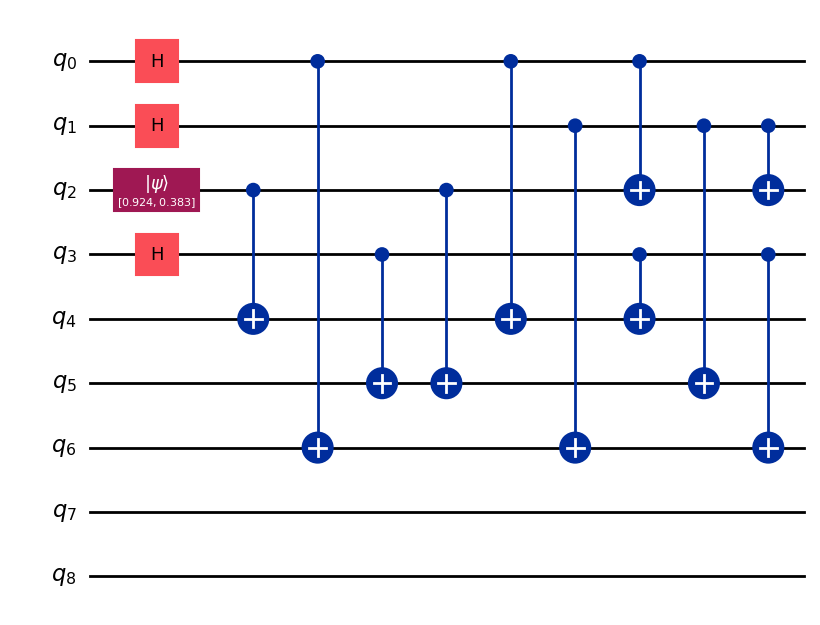

In [28]:
# examine preparation circuits
init = 'h'
lq = LogicalQubit(f"lq_{init}", initial_state=init)
print(f'|{init}>_L preparation circuit')
lq.circuit.draw(output='mpl')

## ***FINAL EFFECTIVE ERROR CHANNEL CODE***

### ***INJECTION CIRCUIT EEC***

In [29]:
def obtain_tomog_final_state(ref_dict, tomog_state, sign):
    ''' obtain the final perfect tomography state for comparison '''
    if tomog_state == '0':
        if sign == +1:
            tomog_final = ref_dict["tomog_posrot_0"]
        else:
            tomog_final = ref_dict["tomog_negrot_0"]
    elif tomog_state == '+':
        if sign == +1:
            tomog_final = ref_dict["tomog_posrot_plus"]
        else:
            tomog_final = ref_dict["tomog_negrot_plus"]
    elif tomog_state == '+i':
        if sign == +1:
            tomog_final = ref_dict["tomog_posrot_i"]
        else:
            tomog_final = ref_dict["tomog_negrot_i"]
    else:
        raise ValueError("tomog_state not found !!" )
    return tomog_final

def cl_data_to_logical(bits):
    """ convert 7-bit classical measurement string to logical (parity) bit"""
    # convert bitstring into list of integers
    if isinstance(bits, str):
        vals = [int(b) for b in bits]
    else:
        vals = list(bits)
    if len(vals) != 7 or any(b not in (0,1) for b in vals):
        raise ValueError("Expected 7 classical bits (0/1)")
    
    # compute parity of logical representaive
    log_rep=(0,1,4)
    parity = sum(vals[i] for i in log_rep) % 2
    return parity  

# test cl_data_to_logical fn
assert cl_data_to_logical('0000000') == 0
assert cl_data_to_logical('1100000') == 0 
assert cl_data_to_logical('1001000') == 1



def injection_eec(p, shots, sign):
    '''extract logical pauli error probabilities for the injection circuit using one-qubit process tomography. 
       *** need to edit to use ancilla measurement outcomes for qec, then should scale with p^2 instead of p *** '''

    # build logical qubits
    lq0 = LogicalQubit(name='lq0', encode=False)
    lq1 = LogicalQubit(name='lq1', encode=False)
    lq1.retarget(offset=9)

    # --- construct noise models and simulators ---
    # t1, noise on transversal cx
    noise_t1 = NoiseModel()
    noise_t1.add_all_qubit_quantum_error(depolarizing_error(p, 2), ['cy'])
    sim_t1   = AerSimulator(method='statevector')

    # t2, noise on logical Ry(\pm pi/2)
    noise_t2 = NoiseModel()
    noise_t2.add_all_qubit_quantum_error(depolarizing_error(p, 1), ['phys_unitary_for_Sy', 'phys_unitary_for_Sydag'])
    sim_t2   = AerSimulator(method='statevector')

    F = {}
    # loop through three tomogoraphy states
    for tomog_state in ['0','+','+i']:
        # obtain initial and final states for tomography (noiseless)
        print(f'initial state: {tomog_state}')
        tomog_init         = steane_logical_states[tomog_state]
        tomog_final_vector = obtain_tomog_final_state(steane_logical_states, tomog_state, sign)
        tomog_final_dm     = DensityMatrix(Statevector(tomog_final_vector))
        
        shot_fidelity = np.zeros(shots)
        for shot in range(shots):
            # 1. initialize and apply transversal cy
            qc_t1 = QuantumCircuit(18)                          # could make this 14 qubits (no qec in this timestep), but would require editing LQ class
            qc_t1.initialize(tomog_init, lq1.data_qubits)
            qc_t1.initialize(steane_logical_states['h'], lq0.data_qubits)
            for q in lq0.data_qubits:
                qc_t1.cy(q, q+9)

            # 2. perfect measurement in the y-basis (no noise because noise model only includes cy)
            creg_corr_meas = ClassicalRegister(7, 'lq0_corr_data_cl')
            qc_t1.add_register(creg_corr_meas)     
            lq0.logical_sdg(circuit=qc_t1)                                                               # rotate measurement into y-basis (HSdg, http://bit.ly/4ll96Ek)
            lq0.logical_h(circuit=qc_t1)                     

            qc_t1.measure(lq0.data_qubits[::-1], creg_corr_meas)                                         # (reverse so qubit 0 ends up as leftmost bit in memory string)
        
            # save lq1 dm after measurement (need to feed into timestep 2)
            lq1_qubits = lq1.data_qubits + [lq1.anc_x, lq1.anc_z]
            qc_t1.save_density_matrix(label='rho_lq1_precorr', qubits=lq1_qubits, pershot=True)          # (qiskit does this under the hood with an efficient method and does not assemble the entire 2**18 x 2**18 dm to partial trace)
       

            # 3. run qc_t1 (first timestep), obtain dm, convert to numpy statevector (since it will be pure per shot)
            t1_res = sim_t1.run(qc_t1, noise_model=noise_t1, shots=1, memory=True).result()
            rho_lq1_precorr = DensityMatrix(t1_res.data(qc_t1)['rho_lq1_precorr'][0])
            psi_lq1_precorr = rho_lq1_precorr.to_statevector().data
            # print(f'shape: {psi_lq1_precorr.shape}')

            # 4. extract logical value of measured qubits
            mem = t1_res.get_memory(qc_t1)[0]                               # full bitstring over all classical bits
            cl_meas7 = mem[-7:]                                             # last seven bits we measured
            corr_cl_logical = cl_data_to_logical(cl_meas7)

            # 5. initialize circuit for timestep 2
            qc_t2 = QuantumCircuit(9)
            lq1_t2 = LogicalQubit(name='lq1_t2', encode=False)
            qc_t2.initialize(psi_lq1_precorr, lq1_t2.data_qubits + [lq1_t2.anc_x, lq1_t2.anc_z])

            # 6. determine if correction is needed or not
            if sign == +1:
                apply_correction = (corr_cl_logical == 0)
            elif sign == -1:
                apply_correction = (corr_cl_logical == 1)
            else:
                raise ValueError("sign must be +1 or -1")

            # 7. apply Y(plus or minus pi/2) correction if needed (with noise)
            if apply_correction:
                lq1_t2.logical_ry_pi2(sign=sign, circuit=qc_t2)

            # qc_t2.save_density_matrix(label='rho_lq1_preqec', qubits=lq1_t2.data_qubits, pershot=True)

            # # inject a physical weight-2 error before QEC (uncorrectable)
            # qc_t2.x([lq1_t2.data_qubits[0], lq1_t2.data_qubits[1]])

            # # 8. perform qec (noiseless, noise_t2 only hits Sy / Sydag
            _, xr1, zr1 = lq1_t2.single_round_error_detection(circuit=qc_t2, save_state_vector=False)
            lq1_t2.decode_and_recover(xr=xr1, zr=zr1, circuit=qc_t2)
            qc_t2.save_density_matrix(label='rho_lq1_final', qubits=lq1_t2.data_qubits, pershot=True)
            
            # 9. simulate t2 (noise only on Sy / Sydag) 
            t2_res = sim_t2.run(qc_t2, noise_model=noise_t2, shots=1).result()
            rho_dm = t2_res.data(qc_t2)['rho_lq1_final'][0]  
            rho_noisy = DensityMatrix(rho_dm)           

            # compute fidelity against perfect tomog_final_dm
            shot_fidelity[shot] = state_fidelity(tomog_final_dm, rho_noisy)
            # print(f'shot_fidelity{[shot]}: {shot_fidelity[shot]}')

            # progress check
            # if ((shot+1) % (shots / 20)) == 0:
            #     print(f'shot: {shot+1} of {shots}')

        F[tomog_state] = shot_fidelity.mean()

    print(f"F0: {F['0']}, F+: {F['+']}, Fi: {F['+i']}")

    # construct and solve system of equations (see notes)
    a = 1 - F['0']
    b = 1 - F['+']
    c = 1 - F['+i']
    px = (a + c - b) / 2
    py = (a + b - c) / 2
    pz = (b + c - a) / 2
    px, py, pz = [np.clip(v, 0, 1) for v in (px, py, pz)]           # clip so that tiny negatives don't break error_channel

    eec_vals = [np.round(px, 5), np.round(py, 5), np.round(pz, 5)]
    print(f'px: {np.round(px, 5)}, py: {np.round(py, 5)}, pz: {np.round(pz, 5)}')
    error_channel = pauli_error([('I', 1 - (px+py+pz)), ('X', px), ('Y', py), ('Z', pz)])
    # return qc_t1, qc_t2, eec_vals, error_channel
    return eec_vals, error_channel


# qc_t1, qc_t2, eec_vals, error_channel = injection_eec(p=0.1, shots=500, sign=+1)

injection_eec0 = {}
shots = 10
# for per in [0.001, 0.003, 0.005]:
for per in [0]:
    print(f'\n########################################')
    print(f'physical error rate = {per}, shots = {shots}') 
    eec_vals, error_channel = injection_eec(p=per, shots=shots, sign=+1)
    injection_eec0[per] = (eec_vals, error_channel)



########################################
physical error rate = 0, shots = 10
initial state: 0
initial state: +
initial state: +i
F0: 1.0000000000000213, F+: 1.0000000000000218, Fi: 1.000000000000022
px: 0.0, py: 0.0, pz: 0.0


In [30]:
'''debugging'''
# qc_t2.draw('mpl')

# # without QEC over 50 shots each tomog state:
# # F0: 0.5400000000000117, F+: 0.46000000000001007, Fi: 0.3400000000000075
# # px: 0.29, py: 0.17, pz: 0.37

# # with QEC over 50 shots each tomog state:
# # F0: 0.9000000000000206, F+: 0.8600000000000196, Fi: 0.9000000000000196
# # px: 0.03, py: 0.07, pz: 0.07

# # construct a p vs LER plot?

'debugging'

### ***TRANSVERSAL CNOT EEC***

In [31]:
from collections import Counter

# ----- helper functions, testing for these functions is in cell below -----

def _measure_logical_block(qc, lq, basis, reg_name):
    '''helper: rotate to basis and measure the 7 data qubits of lq into a fresh creg'''
    cr = ClassicalRegister(7, reg_name)
    qc.add_register(cr)
    if basis == 'X':
        lq.logical_h(circuit=qc)
    elif basis == 'Y':
        lq.logical_sdg(circuit=qc); 
        lq.logical_h(circuit=qc)   

    qc.measure(lq.data_qubits[::-1], cr)  # reverse so phys 0 is leftmost bit (Qiskit uses little-endian !)
    return cr

def _split_bits(mem):
    '''function to extract our two 7-bit measurement chunks from a memory string;
       e.g., takes '0000000 1111111' and returns ('0000000', '1111111')'''
    toks = mem.split()
    seven_bit = [t for t in toks if all(ch in '01' for ch in t) and len(t) == 7]
    if len(seven_bit) < 2:
        raise ValueError(f"Could not find two 7-bit tokens in memory: {mem!r}")
    # assume order matches our measurement order: first is lq0, second is lq1
    b0, b1 = seven_bit[0], seven_bit[1]
    return b0, b1

def _run_counts_chunked(sim, qc, noise, shots, chunk=2000):
    '''run qc in chunks (for efficiency) and return a merged counts dict'''
    counts = Counter()
    tqc = transpile(qc, backend=sim, optimization_level=0)
    todo = shots
    while todo > 0:
        b = min(chunk, todo)
        res = sim.run(tqc, noise_model=noise, shots=b, memory=False).result()
        counts.update(res.get_counts(tqc))
        todo -= b
    return dict(counts)

# ----- construct cnot eec -----

def cnot_eec(p, shots):
    ''' extract two-qubit Pauli error channel for our transversal cnot via process tomography'''

    # build logical qubits
    lq0 = LogicalQubit(name='lq0', encode=False)
    lq1 = LogicalQubit(name='lq1', encode=False)
    lq1.retarget(offset=9)

    # construct noise model and simulator; staying mindful to add errors to only logical cnot, not cnots in qec !!!
    pairs = [(a, b) for a, b in zip(lq0.data_qubits, lq1.data_qubits)]      # it is easy to check that no noise on qec cnots — qec decreases error rate for any p
    noise = NoiseModel()
    tcx_error = depolarizing_error(p, 2)
    for ctrl, targ in pairs:
        noise.add_quantum_error(tcx_error, 'cx', qubits=[ctrl, targ])
    sim   = AerSimulator(method='statevector')                              # eventually switch to stabilizer simulator for efficiency
    sim.set_options(max_parallel_experiments=9, max_parallel_threads=0)     # parallelize for effiency

    # tomography settings in the exact order used by the 15×15 matrix M to solve our system of equations
    # THIS IS ESSENTIALLY TABLE 3 FROM ARON MARTON's MASTER's THESIS WITH A MISTAKE CORRECTED (see aron_thesis_mistake?.ipynb) 
    # (note we also don't insert four of the probabilities since not used in sys of eqns)
    # each entry: (tomog_2q_init, (meas basis lq0, meas basis lq1), "outcome")
    # "outcome" specifies which logical measurement results are counted as an "error event"
    # e.g., ['10','01','11'] counts each of the three cases (−,+), (+,−), (−,−) as separate rows in meas_prob_vec
    tomog_init = [                       
        ('00', ('Z','Z'),  ['10','01','11']),  
        ('0+', ('Z','X'),  ['10','01']),   
        ('0i', ('Z','Y'),  ['10','01']),       
        ('i+', ('Y','X'),  ['10','01']),    
        ('++', ('X','X'),  ['10','01']),    
        ('+0', ('Y','Y'),  ('joint', 0)),  # error case is eignevalue +1 for joint measurement (see aron_thesis_mistake?.ipynb) 
        ('+i', ('Y','Z'),  ('joint', 1)), 
        ('i0', ('X','Y'),  ('joint', 1)), 
        ('ii', ('X','Z'),  ('joint', 0)),  # error case is eignevalue +1 for joint measurement (see aron_thesis_mistake?.ipynb) 
    ]

    # map characters to our key in Steane logical (need so 'i' to '+i')
    key = {'0': '0', '+': '+', 'i': '+i'}

    # measured probability vector (15×1), the known column vector in our system of equations (see Marton thesis)
    meas_prob_vec = []

    # iterate over tomography settings
    for tomog_2qinit_name, (mb0, mb1), outcomes in tomog_init:
        s0, s1 = key[tomog_2qinit_name[0]], key[tomog_2qinit_name[1]]
        print(f"prep {tomog_2qinit_name}, measure ({mb0},{mb1})")

        # initialize an apply transverasl CNOT
        qc = QuantumCircuit(18)
        qc.initialize(steane_logical_states[s0], lq0.data_qubits)
        qc.initialize(steane_logical_states[s1], lq1.data_qubits)
        for q in lq0.data_qubits:
            qc.cx(q, q+9)

        # one round of perfect qec (noise model not attached to these cnots)
        _, xr0, zr0 = lq0.single_round_error_detection(circuit=qc, save_state_vector=False)
        lq0.decode_and_recover(xr=xr0, zr=zr0, circuit=qc)
        _, xr1, zr1 = lq1.single_round_error_detection(circuit=qc, save_state_vector=False)
        lq1.decode_and_recover(xr=xr1, zr=zr1, circuit=qc)

        # logical measurements
        _measure_logical_block(qc, lq0, mb0, 'm0')
        _measure_logical_block(qc, lq1, mb1, 'm1')

        # splits total shot budget into chunks for efficiency
        counts = _run_counts_chunked(sim, qc, noise, shots, chunk=2000)
        tot = sum(counts.values())

        # counters used to determine probabilies for meas_prob_vec
        c10 = c01 = c11 = cxor = 0
        for key_str, n in counts.items():
            bit_string0, bit_string1 = _split_bits(key_str)           # split the raw memory string (14 bits) into the two logical blocks (7 bits)
            logical_b0 = cl_data_to_logical(bit_string0)              # decode each block to a single logical
            logical_b1 = cl_data_to_logical(bit_string1)

            # explicit pairs: count how often we see (-,+), (+,-), and (-,-)
            if isinstance(outcomes, list):
                if logical_b0==1 and logical_b1==0: c10 += n  # (-,+)
                if logical_b0==0 and logical_b1==1: c01 += n  # (+,-)
                if logical_b0==1 and logical_b1==1: c11 += n  # (-,-)
            else:  # ('joint', error_bit)
                prod_bit = logical_b0 ^ logical_b1                
                error_bit = outcomes[1]           
                # if computed parity matches error_bit, add to count
                if prod_bit == error_bit:
                    cxor += n

        # append normalized probabilities to measurement vector
        if isinstance(outcomes, list):
            if '10' in outcomes: meas_prob_vec.append(c10 / tot)
            if '01' in outcomes: meas_prob_vec.append(c01 / tot)
            if '11' in outcomes: meas_prob_vec.append(c11 / tot)
        else:
            meas_prob_vec.append(cxor / tot)

        # # show progress
        # if (shot+1) % max(1, shots//20) == 0:
        #     print(f"  {shot+1}/{shots}", end='\r')

    meas_prob_vec = np.array(meas_prob_vec, dtype=float).reshape(15)

    row_labels = ["P^ZZ_00(-,+)","P^ZZ_00(+,-)","P^ZZ_00(-,-)",
                    "P^ZX_0+(-,+)","P^ZX_0+(+,-)",
                    "P^ZY_0i(-,+)","P^ZY_0i(+,-)",
                    "P^YX_i+(-,+)","P^YX_i+(+,-)",
                    "P^XX_++(-,+)","P^XX_++(+,-)",
                    "P^YY_+0(-)","P^YZ_+i(-)","P^XY_i0(-)","P^XZ_ii(-)"]
    for lab,val in zip(row_labels, meas_prob_vec):
        print(f"{lab}: {val:.6f}")

    # Solve meas_prob_vec = M * pauli_probs (eqn 23 Marton thesis) to get pauli_probs = [pIX, pIY, ..., pZZ]
    M = np.array([
        [0,0,0, 1,0,0,1, 1,0,0,1, 0,0,0,0],
        [1,1,0, 0,0,0,0, 0,0,0,0, 0,1,1,0],
        [0,0,0, 0,1,1,0, 0,1,1,0, 0,0,0,0],
        [0,0,0, 1,1,0,0, 1,1,0,0, 0,0,0,0],
        [0,1,1, 0,0,0,0, 0,0,0,0, 0,1,1,0],
        [0,0,0, 1,0,1,0, 1,0,1,0, 0,0,0,0],
        [1,0,1, 0,0,0,0, 0,0,0,0, 0,1,0,1],
        [0,0,0, 1,1,0,0, 0,0,0,0, 1,1,0,0],
        [0,1,1, 0,0,0,0, 0,0,1,1, 0,0,0,0],
        [0,0,0, 0,0,0,0, 1,1,0,0, 1,1,0,0],
        [0,1,1, 0,0,1,1, 0,0,0,0, 0,0,0,0],
        [1,0,1, 1,0,1,0, 0,1,0,1, 1,0,1,0],
        [1,1,0, 1,0,0,1, 0,1,1,0, 1,0,0,1],
        [1,0,1, 0,1,0,1, 1,0,1,0, 1,0,1,0],
        [1,1,0, 0,1,1,0, 1,0,0,1, 1,0,0,1],
    ], dtype=int)

    # assert np.linalg.matrix_rank(M) == 15

    # solve system of equations, add pII for completeness
    pauli_probs = np.linalg.solve(M, meas_prob_vec)

    # clip and normalize
    pauli_probs = np.clip(pauli_probs, 0.0, 1.0)
    total = pauli_probs.sum()
    pauli_probs /= total if total > 1 else 1

    # define dictionary
    labels = ['IX','IY','IZ','XI','XX','XY','XZ','YI','YX','YY','YZ','ZI','ZX','ZY','ZZ']
    p_dict = {lab: float(val) for lab, val in zip(labels, pauli_probs)}
    pII = max(0.0, 1.0 - float(np.sum(pauli_probs)))
    p_dict = {'II': pII, **p_dict}

    print("\nSolved logical Pauli channel (2-qubit):")
    for k in ['II','IX','IY','IZ','XI','XX','XY','XZ','YI','YX','YY','YZ','ZI','ZX','ZY','ZZ']:
        print(f"  p_{k} = {p_dict[k]:.6f}")

    # build a Qiskit two-qubit effective pauli error channel
    eec = pauli_error([(k, v) for k, v in p_dict.items()])

    return p_dict, eec


cnot_eec0 = {}
shots = 10
# for per in [0.001, 0.003, 0.005]:
for per in [0.0]:
    print(f'\n#############################')
    print(f'physical error rate: {per}, shots: {shots}\n')
    pauli_probs, eec = cnot_eec(p=per, shots=shots)
    cnot_eec0[per] = (pauli_probs, eec)


#############################
physical error rate: 0.0, shots: 10

prep 00, measure (Z,Z)
prep 0+, measure (Z,X)
prep 0i, measure (Z,Y)
prep i+, measure (Y,X)
prep ++, measure (X,X)
prep +0, measure (Y,Y)
prep +i, measure (Y,Z)
prep i0, measure (X,Y)
prep ii, measure (X,Z)
P^ZZ_00(-,+): 0.000000
P^ZZ_00(+,-): 0.000000
P^ZZ_00(-,-): 0.000000
P^ZX_0+(-,+): 0.000000
P^ZX_0+(+,-): 0.000000
P^ZY_0i(-,+): 0.000000
P^ZY_0i(+,-): 0.000000
P^YX_i+(-,+): 0.000000
P^YX_i+(+,-): 0.000000
P^XX_++(-,+): 0.000000
P^XX_++(+,-): 0.000000
P^YY_+0(-): 0.000000
P^YZ_+i(-): 0.000000
P^XY_i0(-): 0.000000
P^XZ_ii(-): 0.000000

Solved logical Pauli channel (2-qubit):
  p_II = 1.000000
  p_IX = 0.000000
  p_IY = 0.000000
  p_IZ = 0.000000
  p_XI = 0.000000
  p_XX = 0.000000
  p_XY = 0.000000
  p_XZ = 0.000000
  p_YI = 0.000000
  p_YX = 0.000000
  p_YY = 0.000000
  p_YZ = 0.000000
  p_ZI = 0.000000
  p_ZX = 0.000000
  p_ZY = 0.000000
  p_ZZ = 0.000000


## ***SAVE SIMULATION DATA*** ##

In [32]:
# interrupt code to ensure saving correct file_name !
KeyboardInterrupt

KeyboardInterrupt

In [ ]:
# save dictionary data for later (REPLACE FILENAME APPROPRIATELY) !!!
import pickle, datetime as dt

def save_dict(data, name):
    fname = f"{name}_{dt.datetime.now():%Y%m%d-%H%M%S}.pkl"
    with open(fname, "wb") as f:
        pickle.dump(data, f, protocol=pickle.HIGHEST_PROTOCOL)
    print(f"Saved {name} to {fname}")

save_dict(injection_eec_REPLACE_FILENAME, "injection_eec_REPLACE_FILENAME")
save_dict(cnot_eec_REPLACE_FILENAME, "cnot_eec_REPLACE_FILENAME")

Saved injection_eec_smallp to injection_eec_smallp_20250828-213508.pkl
Saved cnot_eec_smallp to cnot_eec_smallp_20250828-213508.pkl


## ***RETRIEVE EEC DATA AND PLOT*** ##

In [34]:
'''import previous data'''
import pickle, glob

def load_latest(name):
    # obtain all matching pickle files
    files = sorted(glob.glob(f"{name}_*.pkl"))
    if not files:
        raise FileNotFoundError(f"No saved files found for {name}")
    latest_file = files[-1]  # last in sorted list = newest (since timestamp in name)
    print(f"{latest_file} loaded")
    with open(latest_file, "rb") as f:
        return pickle.load(f)

# load the dictionaries
injection_eec_alltrials = load_latest("injection_eec_alltrials")
cnot_eec_alltrials = load_latest("cnot_eec_alltrials")

# i re-ran the sims for small_p vals with more shots in an attempt to obtain lower error
injection_eec_smallp = load_latest("injection_eec_smallp") 
cnot_eec_smallp = load_latest("cnot_eec_smallp_updated")

injection_eec_alltrials_20250810-204146.pkl loaded
cnot_eec_alltrials_20250810-204146.pkl loaded
injection_eec_smallp_20250828-213508.pkl loaded
cnot_eec_smallp_updated_20250811-080625.pkl loaded


In [35]:
injection_eec_alltrials[0.01]

([0.0, 0.007, 0.002],
 <QuantumError[c136879236144bebaba227ced9ef1b30], num_qubits=1, size=3, probabilities=[0.9910000000000216, 0.006999999999989348, 0.0019999999999890106]>)

In [36]:
'''add small_p dictionaries to alltrials'''
cnot_combined_dicts = cnot_eec_alltrials.copy()
injection_combined_dicts = injection_eec_alltrials.copy()

for p in [0, 0.001, 0.003, 0.005]:
    if p in cnot_eec_smallp:
        cnot_combined_dicts[p] = cnot_eec_smallp[p]
    else:
        print(f"Warning: key {p} not found.")

    if p in injection_eec_smallp:
        injection_combined_dicts[p] = injection_eec_smallp[p]
    else:
        print(f"Warning: key {p} not found.")

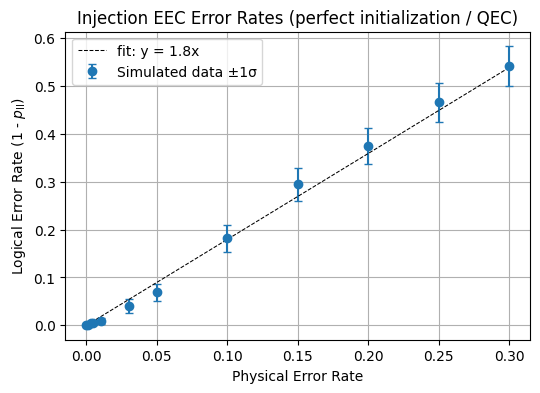

In [37]:
''' plot injection eec summed "logical error rate" '''

x_vals = np.array(sorted(injection_combined_dicts.keys()))

# error probs per point 
pxyz = np.array([injection_combined_dicts[x][0] for x in x_vals]) 
px, py, pz = pxyz[:,0], pxyz[:,1], pxyz[:,2]
y_vals = px + py + pz

# reconstruct tomography "q"s from p's for error bar calculation
qX = py + pz
qY = px + pz
qZ = px + py

# shots per point: 1500 for certain small_p, else 1000
small_p_vals = {0.001, 0.003, 0.005}
N = np.array([1500 if x in small_p_vals else 1000 for x in x_vals], dtype=float)

# analytic SE for L (elementwise division by N)
var_ler = 0.25 * (qX*(1-qX)*10/N + qY*(1-qY)*10/N + qZ*(1-qZ)*10/N)
y_errs = np.sqrt(var_ler)

# weighted fit through origin using 1/sigma^2, *** SHOULD BECOME QUADRATIC AFTER FIX ***
mask = y_errs > 0
w = 1.0 / (y_errs[mask]**2)
slope = np.sum(w * x_vals[mask] * y_vals[mask]) / np.sum(w * x_vals[mask]**2)

# plot
x_fit = np.linspace(float(x_vals.min()), float(x_vals.max()), 200)
y_fit = slope * x_fit

plt.figure(figsize=(6,4))
plt.errorbar(x_vals, y_vals, yerr=y_errs, fmt='o', capsize=3, label="Simulated data ±1σ")
plt.plot(x_fit, y_fit, linestyle='--', linewidth=0.75, color='black', label=f"fit: y = {slope:.3g}x")
plt.xlabel("Physical Error Rate")
plt.rcParams['text.usetex'] = False 
plt.ylabel(r"Logical Error Rate (1 - $p_{\mathrm{II}}$)")
plt.title("Injection EEC Error Rates (perfect initialization / QEC)")
plt.grid(True)
plt.legend()
# plt.xlim(0, 0.008)
# plt.ylim(0, 0.008)
plt.show()

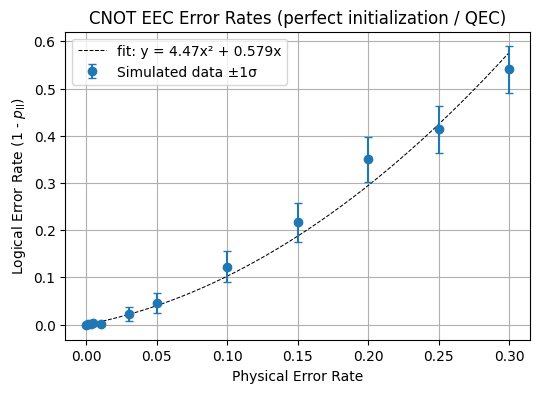

In [38]:
rng = np.random.default_rng(123)

# shot count mapping
small_p_shots = {0.001: 500, 0.003: 500, 0.005: 500}
default_shots = 100

# --- helper functions to calculate error bars ---
def have_meas_dict(entry):
    if isinstance(entry, dict) and 'meas' in entry: 
        return True
    if isinstance(entry, (list, tuple)) and len(entry) >= 3 and isinstance(entry[2], dict): 
        return True
    return False

def get_meas_dict(entry):
    return entry['meas'] if isinstance(entry, dict) else entry[2]

def group_by_setting(meas_probs):
    groups = {}
    for k in meas_probs:
        setting = k.split('(')[0]
        groups.setdefault(setting, []).append(k)
    return groups

def solve_from_meas(meas_probs):
    raise NotImplementedError("Plug your tomography inversion here if using bootstrap.")

def bootstrap_sigma_L(meas_probs, draws, N):
    groups = group_by_setting(meas_probs)
    Ls = []
    for _ in range(draws):
        boot_probs = {}
        for _, keys in groups.items():
            probs  = np.array([meas_probs[k] for k in keys], float)
            p_rest = max(0.0, 1.0 - probs.sum())
            counts = rng.multinomial(N, np.append(probs, p_rest))
            for k, v in zip(keys, counts[:-1] / N):
                boot_probs[k] = v
        p_star = solve_from_meas(boot_probs)
        Ls.append(1.0 - float(p_star.get('II', 0.0)))
    return np.std(Ls, ddof=1)

# --- build arrays ---
x = np.array(sorted(cnot_combined_dicts.keys()))
pII = np.array([cnot_combined_dicts[p][0].get('II', 0.0) for p in x])
y = 1.0 - pII

# build shots array
shots_per_point = np.array([small_p_shots.get(float(val), default_shots) for val in x])

# choose error-bar method
if have_meas_dict(cnot_combined_dicts[x[0]]):
    meas_per_point = [get_meas_dict(cnot_combined_dicts[p]) for p in x]
    yerr = np.array([
        bootstrap_sigma_L(meas, draws=1500, N=int(shots))
        for meas, shots in zip(meas_per_point, shots_per_point)
    ], float)
else:
    yerr = np.sqrt(np.maximum(pII*(1.0 - pII), 0.0) / shots_per_point)

# weighted quadratic fit through origin
X = np.column_stack((x**2, x))
w = 1.0 / np.maximum(yerr, 1e-12)**2
XtWX = (X.T * w) @ X
XtWy  = (X.T * w) @ y
a, b = np.linalg.solve(XtWX, XtWy)

# Plot
x_fit = np.linspace(x.min(), x.max(), 200)
y_fit = a * x_fit**2 + b * x_fit

plt.figure(figsize=(6,4))
plt.grid(True, zorder=1)
plt.errorbar(x, y, yerr=yerr, fmt='o', capsize=3, label='Simulated data ±1σ', zorder=3)
plt.plot(x_fit, y_fit, '--', lw=0.75, color='black',
         label=f'fit: y = {a:.3g}x² + {b:.3g}x', zorder=2)
plt.xlabel("Physical Error Rate")
plt.ylabel(r"Logical Error Rate (1 - $p_{\mathrm{II}}$)")
plt.title("CNOT EEC Error Rates (perfect initialization / QEC)")
plt.legend()
# plt.xlim(0, 0.008)
# plt.ylim(0, 0.008)
plt.show()

## ***Test helper fns from CNOT_EEC*** 

In [39]:
'''tests for our helper functions used in cnot_eec'''
print('--- testing our helper functions (thanks chatgpt) ---')

# Build a simulator
sim = AerSimulator(method='statevector')

# Logical Z test: |0>_L should give all +1 in Z-basis
lq = LogicalQubit(name='lq', encode=True, initial_state='0')
qc = lq.circuit.copy()
_measure_logical_block(qc, lq, 'Z', 'm')
res = sim.run(qc, shots=10, memory=True).result()
assert all(cl_data_to_logical(mem.split()[0]) == 0 for mem in res.get_memory()), "Z-basis |0>_L failed"

# Logical X test: |+>_L should give all +1 in X-basis
lq = LogicalQubit(name='lq', encode=True, initial_state='+')
qc = lq.circuit.copy()
_measure_logical_block(qc, lq, 'X', 'm')
res = sim.run(qc, shots=10, memory=True).result()
assert all(cl_data_to_logical(mem.split()[0]) == 0 for mem in res.get_memory()), "X-basis |+>_L failed"

# Logical Y test: |+i>_L should give all +1 in Y-basis
lq = LogicalQubit(name='lq', encode=True, initial_state='+i')
qc = lq.circuit.copy()
_measure_logical_block(qc, lq, 'Y', 'm')
res = sim.run(qc, shots=10, memory=True).result()
assert all(cl_data_to_logical(mem.split()[0]) == 0 for mem in res.get_memory()), "Y-basis |+i>_L failed"

print("All _measure_logical_block tests passed.")


# ---------- cl_data_to_logical tests ----------
# +1 eigenvalue (even parity on indices 0,1,4)
assert cl_data_to_logical('0000000') == 0
assert cl_data_to_logical('1100000') == 0   # 1+1+0=2

# −1 eigenvalue (odd parity on indices 0,1,4)
assert cl_data_to_logical('1000000') == 1   # 1+0+0=1
assert cl_data_to_logical('0010100') == 1   # 0+0+1=1


# error on wrong length
try:
    cl_data_to_logical('010')               # too short
    assert False, "Expected ValueError for length≠7"
except ValueError:
    pass
print("All cl_data_to_logical tests passed.")



# ---------- _split_bits tests ----------
# picks the first two 7-bit tokens from a space-separated memory string
mem1 = "000 111 0101010 1011000 001 010"
assert _split_bits(mem1) == ('0101010','1011000')

# works when the two 7-bit logical registers are at the end
mem2 = "000 011 001 010 1010101 0011011"
assert _split_bits(mem2) == ('1010101','0011011')

# error when fewer than two 7-bit tokens are present
try:
    _split_bits("000 011 111 010")          # only 3-bit tokens
    assert False, "Expected ValueError for <2 seven-bit tokens"
except ValueError:
    pass
print("All _split_bits tests passed.")


print('\nFurther testing:')

# 1) Exhaustive parity sanity: cl_data_to_logical equals direct parity on (0,1,4)
for n in range(128):
    bits = f"{n:07b}"
    expect = (int(bits[0]) + int(bits[1]) + int(bits[4])) % 2
    assert cl_data_to_logical(bits) == expect
print("cl_data_to_logical exhaustive parity test passed.")

# 2) Negative-eigenvalue cases for _measure_logical_block
sim = AerSimulator(method='statevector')

# |1>_L measured in Z → always -1 (parity 1)
lq = LogicalQubit(name='lq', encode=True, initial_state='1')
qc = lq.circuit.copy()
_measure_logical_block(qc, lq, 'Z', 'm')
mem = sim.run(qc, shots=10, memory=True).result().get_memory()
assert all(cl_data_to_logical(m.split()[-1]) == 1 for m in mem)

# |->_L in X → always -1
lq = LogicalQubit(name='lq', encode=True, initial_state='-')
qc = lq.circuit.copy()
_measure_logical_block(qc, lq, 'X', 'm')
mem = sim.run(qc, shots=10, memory=True).result().get_memory()
assert all(cl_data_to_logical(m.split()[-1]) == 1 for m in mem)

# |-i>_L in Y → always -1
lq = LogicalQubit(name='lq', encode=True, initial_state='-i')
qc = lq.circuit.copy()
_measure_logical_block(qc, lq, 'Y', 'm')
mem = sim.run(qc, shots=10, memory=True).result().get_memory()
assert all(cl_data_to_logical(m.split()[-1]) == 1 for m in mem)

print("_measure_logical_block negative-eigenvalue tests passed.")

# 3) _split_bits against a realistic memory string with extra small syndrome regs
# (Two 7-bit regs somewhere among several 3-bit regs.)
mem = "000 011 101 000 0101010 1011000 001 010"
b0, b1 = _split_bits(mem)
assert b0 == "0101010" and b1 == "1011000"
print("_split_bits mixed-register test passed.")

--- testing our helper functions (thanks chatgpt) ---
All _measure_logical_block tests passed.
All cl_data_to_logical tests passed.
All _split_bits tests passed.

Further testing:
cl_data_to_logical exhaustive parity test passed.
_measure_logical_block negative-eigenvalue tests passed.
_split_bits mixed-register test passed.
